# 1. Libraries

In [ ]:
%conda install -c conda-forge scikit-multiflow

In [1]:
import numpy as np
import pandas as pd

#https://scikit-multiflow.github.io/scikit-multiflow/documentation.html#learning-methods
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.drift_detection.adwin import ADWIN

from skmultiflow.meta import AdaptiveRandomForest
from skmultiflow.evaluation import EvaluatePrequential

from skmultiflow.data import DataStream

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import glob

# 2. Dataset

In [3]:
dataset_scaled = pd.read_csv('Tennessee_Event-Driven/datasets/dataset_standard_scaled.csv',index_col=False)

# 3. Stream Machine Learning

In [35]:
samples = dataset_scaled[dataset_scaled.columns[:-1]]
labels = dataset_scaled[dataset_scaled.columns[-1]].to_frame()

stream = DataStream(data = samples, y = labels)
stream.prepare_for_use()

ARF = AdaptiveRandomForest()

evaluator = EvaluatePrequential(n_wait=200, pretrain_size=200, output_file="Tennessee_Event-Driven/results/py_ARF_results.csv")
# Run evaluation
evaluator.evaluate(stream=stream, model=ARF, model_names=['ARF'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 ###----------------- [15%] [53.22s]

C:\ProgramData\Anaconda3\lib\site-packages\skmultiflow\metrics\measure_collection.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return sum_value / self.sample_count


 #################### [100%] [419.80s]
Processed samples: 31700
Mean performance:
ARF - Accuracy     : 0.9897
ARF - Kappa        : 0.9893


[AdaptiveRandomForest(binary_split=False, disable_weighted_vote=False,
                      drift_detection_method=ADWIN(delta=0.001), grace_period=50,
                      lambda_value=6, leaf_prediction='nba',
                      max_byte_size=33554432, max_features=7,
                      memory_estimate_period=2000000, n_estimators=10,
                      nb_threshold=0, no_preprune=False, nominal_attributes=None,
                      performance_metric='acc', random_state=None,
                      remove_poor_atts=False, split_confidence=0.01,
                      split_criterion='info_gain', stop_mem_management=False,
                      tie_threshold=0.05,
                      warning_detection_method=ADWIN(delta=0.01))]

In [3]:
# skmultiflow saves results to file with leading 5 lines containing configuraiton of evaluation, learner etc
# skmultiflow also did not evaluate last 200 samples
# for the sake of comparisson we shrink the MOA results
# accuracy in MOA is in % and in skmultiflow fraction
py_ARF_results = pd.read_csv('Tennessee_Event-Driven/results/py_ARF_results.csv',skiprows=[0,1,2,3,4],index_col=False)
py_ARF_results['mean_acc_[ARF]'] = py_ARF_results['mean_acc_[ARF]']*100
moa_ARF_results = pd.read_csv('Tennessee_Event-Driven/results/moa_ARF_results.csv',index_col=False)
moa_ARF_results = moa_ARF_results.iloc[:-1]

In [53]:
py_ARF_results.head()

,id,mean_acc_[ARF],current_acc_[ARF],mean_kappa_[ARF],current_kappa_[ARF]
0,200,100.0,1.0,1.0,1.0
1,399,100.0,1.0,1.0,1.0
2,599,100.0,1.0,1.0,1.0
3,799,100.0,1.0,1.0,1.0
4,999,100.0,1.0,1.0,1.0


In [54]:
moa_ARF_results.head()

,learning evaluation instances,evaluation time (cpu seconds),model cost (RAM-Hours),[avg] classified instances,[err] classified instances,[avg] classifications correct (percent),[err] classifications correct (percent),[avg] Kappa Statistic (percent),[err] Kappa Statistic (percent),[avg] Kappa Temporal Statistic (percent),[err] Kappa Temporal Statistic (percent),[avg] Kappa M Statistic (percent),[err] Kappa M Statistic (percent)
0,200.0,0.484375,0.0,200.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
1,400.0,0.578125,0.0,400.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,600.0,0.671875,0.0,600.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
3,800.0,0.765625,0.0,800.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,1000.0,0.843750,0.0,1000.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0


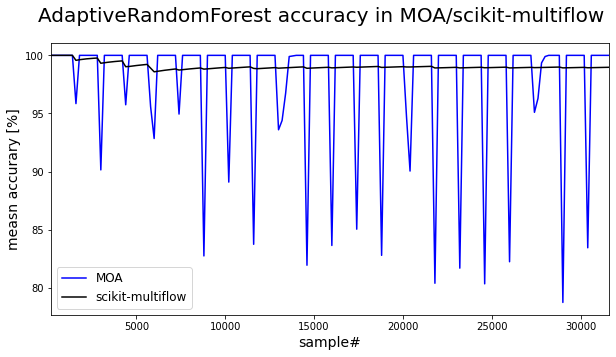

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('AdaptiveRandomForest accuracy in MOA/scikit-multiflow', size=20)
moa_ARF_results.plot(x='learning evaluation instances', y = '[avg] classifications correct (percent)',ax=ax,color='blue')
py_ARF_results.plot(x = 'id',y = 'mean_acc_[ARF]', ax=ax,color='black')
ax.set_xlabel('sample#',size=14)
ax.set_ylabel('measn accurary [%]',size=14)
ax.legend()

ax.legend(['MOA', 'scikit-multiflow'], fontsize=12);

# 4. Concept Drift Detection
I stole this picture from :

    "Gama, J., Žliobaitė, I., Bifet, A., Pechenizkiy, M., & Bouchachia, A. (2014). A survey on concept drift adaptation. ACM computing surveys (CSUR), 46(4), 1-37."
    
I think it nicely shows categoies of concept drifts.
![missing_image](images/Pattern_of_change_over_time_(outlier_is_not_concept_drift).png "Pattern of change over time (outlier is not concept drift)")

In [5]:
# check where the fault_id changes - i.e. the concept_drift should occur and mark that sample with "1" (initial sample has NA - fill with 0)
dataset_scaled['fault_id_change'] = dataset_scaled['fault_id'].diff().fillna(0)

In [6]:
dataset_scaled[dataset_scaled['fault_id_change'] != 0].head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,fault_id,fault_id_change
1460,-0.135542,-0.524896,-0.492994,-0.054211,-0.987287,-1.285137,-0.168249,0.878383,-0.164558,-0.150351,...,-0.276954,0.037310,0.036727,-0.136297,2.061118,-0.065809,-0.150985,-0.452600,1,1.0
2900,-0.030999,-0.343700,-0.419469,0.073448,0.924679,-1.495925,-0.157704,0.953235,-0.164558,-0.069701,...,-0.431869,0.173012,0.076962,-0.154326,-2.714047,-0.134900,-0.156721,-0.289216,2,1.0
4340,0.004211,-0.621376,-0.233271,-0.353160,1.616335,0.794846,-0.243386,-0.039332,0.274466,-0.144001,...,-0.434017,0.052163,0.082485,-1.713662,-1.349287,-0.126842,-0.071859,-0.281409,3,1.0
5780,-0.085480,0.618753,0.693899,-0.421029,1.241872,-0.138201,-0.246023,0.366895,2.762265,-0.090784,...,-0.164783,0.075118,0.024657,-0.346862,-0.140671,-0.152638,0.419007,-0.186864,4,1.0
7220,0.176494,-0.190743,0.045548,-0.043977,1.003977,-0.404786,-0.185386,0.894757,0.128125,-0.039473,...,-0.522443,0.133517,0.077278,2.605128,-0.257992,-0.023297,-0.039635,-0.452504,5,1.0


In [7]:
# magnitude of row vectors - concept drift detectors take as input single value not list/vector
dataset_scaled['magnitude'] = dataset_scaled[dataset_scaled.columns[:-1]].apply(np.linalg.norm, axis=1)
data_stream = dataset_scaled['magnitude'].values

In [8]:
adwin = ADWIN()
ddm = DDM()
eddm = EDDM()
ph = PageHinkley()

# Adding stream elements to ADWIN and verifying if drift occurred
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    #ddm.add_element(data_stream[i])
    #eddm.add_element(data_stream[i])
    #ph.add_element(data_stream[i])
    if ph.detected_change():
        print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 5.419836360231831 - at index: 1332
Change detected in data: 8.115708784797683 - at index: 1489
Change detected in data: 9.922426143216631 - at index: 2144
Change detected in data: 9.17507252067697 - at index: 2961
Change detected in data: 11.706287399517787 - at index: 3093
Change detected in data: 10.388199578893357 - at index: 3643
Change detected in data: 11.282700780357551 - at index: 3789
Change detected in data: 12.094385119244482 - at index: 4183
Change detected in data: 6.6619624804231155 - at index: 7236
Change detected in data: 7.977809655775003 - at index: 7930
Change detected in data: 8.617965851727377 - at index: 8690
Change detected in data: 13.35433457268671 - at index: 8740
Change detected in data: 17.822366005355317 - at index: 8783
Change detected in data: 18.74867411118466 - at index: 8941
Change detected in data: 16.594178889265656 - at index: 9407
Change detected in data: 18.720282142902146 - at index: 9520
Change detected in data: 19.63625